### Model 10 Information
* To test out training of cubes where mask label exists
* No random number generator used
* Training data : 64 x 64 x 96


In [ ]:
# Import Libraries -------------------------------------------------------------------------------------------------------------------------------------------------------------
import os
import h5py
import keras
import loss
import Helper
import allMetrics
import numpy as np
import tensorflow as tf
import UNetModel_3D_simplified
import matplotlib.pyplot as plt
from keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger

In [ ]:
# physical_devices = tf.config.list_physical_devices('GPU')
# print(physical_devices)
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
train_fileName = "/media/dro/JHSeagate/FYP/jh_fyp_work/3D_UNet/trials/numpyDatasets/numPyArrays/train_Scans/train_DS4.hdf5"
train_maskfileName = "/media/dro/JHSeagate/FYP/jh_fyp_work/3D_UNet/trials/numpyDatasets/numPyArrays/train_Mask_Scans/train_maskDS4.hdf5"

train_DatasetName = "trainScans_DataSet4"
train_maskDatasetName = "trainMaskScans_DataSet4"

valid_fileName = "/media/dro/JHSeagate/FYP/jh_fyp_work/3D_UNet/trials/numpyDatasets/numPyArrays/valid_Scans/valid_DS4.hdf5"
valid_maskfileName = "/media/dro/JHSeagate/FYP/jh_fyp_work/3D_UNet/trials/numpyDatasets/numPyArrays/valid_Mask_Scans/valid_maskDS4.hdf5"

valid_DatasetName = "validScans_DataSet4"
valid_maskDatasetName = "validMaskScans_DataSet4"

test_fileName = "/media/dro/JHSeagate/FYP/jh_fyp_work/3D_UNet/trials/numpyDatasets/numPyArrays/test_Scans/test_DS4.hdf5"
test_maskfileName = "/media/dro/JHSeagate/FYP/jh_fyp_work/3D_UNet/trials/numpyDatasets/numPyArrays/test_Mask_Scans/test_maskDS4.hdf5"

test_DatasetName = "testScans_DataSet4"
test_maskDatasetName = "testMaskScans_DataSet4"

In [4]:
with h5py.File(train_fileName, 'r') as hf: # File Dir
    train_array = hf[train_DatasetName][:]
    
with h5py.File(train_maskfileName,'r') as hf:
    train_mask_array = hf[train_maskDatasetName][:]
    
with h5py.File(valid_fileName, 'r') as hf: # File Dir
    valid_array = hf[valid_DatasetName][:]
    
with h5py.File(valid_maskfileName,'r') as hf:
    valid_mask_array = hf[valid_maskDatasetName][:]
    
with h5py.File(test_fileName, 'r') as hf: # File Dir
    test_array = hf[test_DatasetName][:]
    
with h5py.File(test_maskfileName,'r') as hf:
    test_mask_array = hf[test_maskDatasetName][:]

In [5]:
print(train_array.shape)
print(train_mask_array.shape)
print('--')
print(valid_array.shape)
print(valid_mask_array.shape)
print('--')
print(test_array.shape)
print(test_mask_array.shape)

(591, 64, 64, 96)
(591, 64, 64, 96)
--
(225, 64, 64, 96)
(225, 64, 64, 96)
--
(296, 64, 64, 96)
(296, 64, 64, 96)


In [6]:
train_scan = np.concatenate((train_array,valid_array,test_array))
train_mask_scan = np.concatenate((train_mask_array,valid_mask_array,test_mask_array))

In [7]:
train_array = np.expand_dims(train_scan, axis=4)
train_mask_array = np.expand_dims(train_mask_scan, axis=4)

valid_array = np.expand_dims(valid_array, axis=4)
valid_mask_array = np.expand_dims(valid_mask_array, axis=4)

In [8]:
print(train_array.shape)
print(train_mask_array.shape)
print('--')
print(valid_array.shape)
print(valid_mask_array.shape)

(1112, 64, 64, 96, 1)
(1112, 64, 64, 96, 1)
--
(225, 64, 64, 96, 1)
(225, 64, 64, 96, 1)


### Init Model

In [9]:
LR = 0.001
opt = tf.keras.optimizers.Nadam(LR)

input_shape = (64,64,96,1)
num_class = 1

metrics = [allMetrics.dice_coef]

model = UNetModel_3D_simplified.build_unet(input_shape, n_classes = num_class)
model.compile(optimizer=opt, loss=loss.tversky_crossentropy, metrics=metrics)
print(model.summary())

2023-03-02 16:54:19.046642: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-02 16:54:19.530200: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38414 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:47:00.0, compute capability: 8.0


sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 96,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 64, 64, 96,   896         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 96,   128        ['conv3d[0][0]']                 
 alization)                     32)                                                   

In [10]:
csv_path = '/media/dro/JHSeagate/FYP/jh_fyp_work/3D_UNet/Final/CSVLogs/Model10_run4.csv'
model_checkpoint_path = '/media/dro/JHSeagate/FYP/jh_fyp_work/3D_UNet/Final/SavedModels/Model10_run4.hdf5'

In [11]:
my_callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, mode = 'auto'),
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, mode = 'auto'),
    CSVLogger(csv_path, separator=',', append=True),
    ModelCheckpoint(filepath=model_checkpoint_path,
                    monitor='val_loss',
                    mode='auto',
                    verbose=1,
                    save_best_only= True)
]
#     CustomCallBack()

In [12]:
model_name = 'Model10_run4 (300 Epochs)'
# Helper.telegram_bot_sendtext(f'Model {model_name} started training')

history = model.fit(train_array,
                    train_mask_array,
                    batch_size=8,
                    epochs=300,
                    verbose=1,
                    shuffle = True,
                    validation_data=(valid_array, valid_mask_array),
                    callbacks=my_callbacks)

Epoch 1/300


2023-03-02 16:55:22.046228: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301
2023-03-02 16:55:22.908514: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


139/139 [==============================] - ETA: 0s - loss: 0.9850 - dice_coef: 0.2429
Epoch 00001: val_loss improved from inf to 9.25300, saving model to /media/dro/JHSeagate/FYP/jh_fyp_work/3D_UNet/Final/SavedModels/Model10_run4.hdf5
139/139 [==============================] - 42s 231ms/step - loss: 0.9850 - dice_coef: 0.2429 - val_loss: 9.2530 - val_dice_coef: 7.3362e-05 - lr: 0.0010
Epoch 2/300
139/139 [==============================] - ETA: 0s - loss: 0.7756 - dice_coef: 0.4657
Epoch 00002: val_loss improved from 9.25300 to 1.68251, saving model to /media/dro/JHSeagate/FYP/jh_fyp_work/3D_UNet/Final/SavedModels/Model10_run4.hdf5
139/139 [==============================] - 31s 223ms/step - loss: 0.7756 - dice_coef: 0.4657 - val_loss: 1.6825 - val_dice_coef: 7.3046e-05 - lr: 0.0010
Epoch 3/300
139/139 [==============================] - ETA: 0s - loss: 0.6421 - dice_coef: 0.6028
Epoch 00003: val_loss improved from 1.68251 to 1.15902, saving model to /media/dro/JHSeagate/FYP/jh_fyp_work/3

Epoch 27/300
139/139 [==============================] - ETA: 0s - loss: 0.3719 - dice_coef: 0.8452
Epoch 00027: val_loss did not improve from 0.48980
139/139 [==============================] - 30s 213ms/step - loss: 0.3719 - dice_coef: 0.8452 - val_loss: 0.5429 - val_dice_coef: 0.6726 - lr: 0.0010
Epoch 28/300
139/139 [==============================] - ETA: 0s - loss: 0.3688 - dice_coef: 0.8278
Epoch 00028: val_loss did not improve from 0.48980
139/139 [==============================] - 29s 211ms/step - loss: 0.3688 - dice_coef: 0.8278 - val_loss: 0.8507 - val_dice_coef: 0.5086 - lr: 0.0010
Epoch 29/300
139/139 [==============================] - ETA: 0s - loss: 0.3725 - dice_coef: 0.8286
Epoch 00029: val_loss did not improve from 0.48980
139/139 [==============================] - 29s 212ms/step - loss: 0.3725 - dice_coef: 0.8286 - val_loss: 0.9828 - val_dice_coef: 0.4267 - lr: 0.0010
Epoch 30/300
139/139 [==============================] - ETA: 0s - loss: 0.3475 - dice_coef: 0.8358
Epoc

Epoch 53/300
139/139 [==============================] - ETA: 0s - loss: 0.2501 - dice_coef: 0.8987
Epoch 00053: val_loss did not improve from 0.33218
139/139 [==============================] - 29s 211ms/step - loss: 0.2501 - dice_coef: 0.8987 - val_loss: 0.3463 - val_dice_coef: 0.8336 - lr: 5.0000e-04
Epoch 54/300
139/139 [==============================] - ETA: 0s - loss: 0.2558 - dice_coef: 0.8922
Epoch 00054: val_loss did not improve from 0.33218
139/139 [==============================] - 29s 212ms/step - loss: 0.2558 - dice_coef: 0.8922 - val_loss: 0.5059 - val_dice_coef: 0.5701 - lr: 5.0000e-04
Epoch 55/300
139/139 [==============================] - ETA: 0s - loss: 0.2534 - dice_coef: 0.8943
Epoch 00055: val_loss did not improve from 0.33218
139/139 [==============================] - 29s 211ms/step - loss: 0.2534 - dice_coef: 0.8943 - val_loss: 0.4002 - val_dice_coef: 0.8149 - lr: 5.0000e-04
Epoch 56/300
139/139 [==============================] - ETA: 0s - loss: 0.2533 - dice_coef:

Epoch 79/300
139/139 [==============================] - ETA: 0s - loss: 0.1896 - dice_coef: 0.9185
Epoch 00079: val_loss improved from 0.23990 to 0.23488, saving model to /media/dro/JHSeagate/FYP/jh_fyp_work/3D_UNet/Final/SavedModels/Model10_run4.hdf5
139/139 [==============================] - 30s 215ms/step - loss: 0.1896 - dice_coef: 0.9185 - val_loss: 0.2349 - val_dice_coef: 0.8782 - lr: 1.2500e-04
Epoch 80/300
139/139 [==============================] - ETA: 0s - loss: 0.1869 - dice_coef: 0.9181
Epoch 00080: val_loss did not improve from 0.23488
139/139 [==============================] - 29s 212ms/step - loss: 0.1869 - dice_coef: 0.9181 - val_loss: 0.2428 - val_dice_coef: 0.8809 - lr: 1.2500e-04
Epoch 81/300
139/139 [==============================] - ETA: 0s - loss: 0.1867 - dice_coef: 0.9159
Epoch 00081: val_loss did not improve from 0.23488
139/139 [==============================] - 29s 211ms/step - loss: 0.1867 - dice_coef: 0.9159 - val_loss: 0.2507 - val_dice_coef: 0.8812 - lr: 

Epoch 105/300
139/139 [==============================] - ETA: 0s - loss: 0.1637 - dice_coef: 0.9244
Epoch 00105: val_loss did not improve from 0.21078
139/139 [==============================] - 29s 211ms/step - loss: 0.1637 - dice_coef: 0.9244 - val_loss: 0.2112 - val_dice_coef: 0.8892 - lr: 3.1250e-05
Epoch 106/300
139/139 [==============================] - ETA: 0s - loss: 0.1663 - dice_coef: 0.9235
Epoch 00106: val_loss did not improve from 0.21078
139/139 [==============================] - 29s 211ms/step - loss: 0.1663 - dice_coef: 0.9235 - val_loss: 0.2237 - val_dice_coef: 0.8898 - lr: 3.1250e-05
Epoch 107/300
139/139 [==============================] - ETA: 0s - loss: 0.1657 - dice_coef: 0.9220
Epoch 00107: val_loss did not improve from 0.21078
139/139 [==============================] - 29s 212ms/step - loss: 0.1657 - dice_coef: 0.9220 - val_loss: 0.2161 - val_dice_coef: 0.8913 - lr: 3.1250e-05
Epoch 108/300
139/139 [==============================] - ETA: 0s - loss: 0.1643 - dice_c

Epoch 130/300
139/139 [==============================] - ETA: 0s - loss: 0.1584 - dice_coef: 0.9254
Epoch 00130: val_loss did not improve from 0.20224
139/139 [==============================] - 29s 210ms/step - loss: 0.1584 - dice_coef: 0.9254 - val_loss: 0.2069 - val_dice_coef: 0.8945 - lr: 1.5625e-05
Epoch 131/300
139/139 [==============================] - ETA: 0s - loss: 0.1585 - dice_coef: 0.9254
Epoch 00131: val_loss did not improve from 0.20224
139/139 [==============================] - 29s 210ms/step - loss: 0.1585 - dice_coef: 0.9254 - val_loss: 0.2100 - val_dice_coef: 0.8951 - lr: 1.5625e-05
Epoch 132/300
139/139 [==============================] - ETA: 0s - loss: 0.1579 - dice_coef: 0.9240
Epoch 00132: val_loss did not improve from 0.20224
139/139 [==============================] - 29s 210ms/step - loss: 0.1579 - dice_coef: 0.9240 - val_loss: 0.2083 - val_dice_coef: 0.8955 - lr: 1.5625e-05
Epoch 133/300
139/139 [==============================] - ETA: 0s - loss: 0.1592 - dice_c

Epoch 156/300
139/139 [==============================] - ETA: 0s - loss: 0.1543 - dice_coef: 0.9266
Epoch 00156: val_loss did not improve from 0.19843
139/139 [==============================] - 29s 210ms/step - loss: 0.1543 - dice_coef: 0.9266 - val_loss: 0.2020 - val_dice_coef: 0.8956 - lr: 3.9063e-06
Epoch 157/300
139/139 [==============================] - ETA: 0s - loss: 0.1545 - dice_coef: 0.9269
Epoch 00157: val_loss did not improve from 0.19843
139/139 [==============================] - 29s 210ms/step - loss: 0.1545 - dice_coef: 0.9269 - val_loss: 0.2019 - val_dice_coef: 0.8952 - lr: 3.9063e-06
Epoch 158/300
139/139 [==============================] - ETA: 0s - loss: 0.1546 - dice_coef: 0.9265
Epoch 00158: val_loss did not improve from 0.19843
139/139 [==============================] - 29s 210ms/step - loss: 0.1546 - dice_coef: 0.9265 - val_loss: 0.1991 - val_dice_coef: 0.8953 - lr: 3.9063e-06
Epoch 159/300
139/139 [==============================] - ETA: 0s - loss: 0.1558 - dice_c

Epoch 183/300
139/139 [==============================] - ETA: 0s - loss: 0.1546 - dice_coef: 0.9271
Epoch 00183: val_loss did not improve from 0.19843
139/139 [==============================] - 29s 211ms/step - loss: 0.1546 - dice_coef: 0.9271 - val_loss: 0.2030 - val_dice_coef: 0.8960 - lr: 4.8828e-07
Epoch 184/300
139/139 [==============================] - ETA: 0s - loss: 0.1549 - dice_coef: 0.9250
Epoch 00184: val_loss did not improve from 0.19843
139/139 [==============================] - 29s 212ms/step - loss: 0.1549 - dice_coef: 0.9250 - val_loss: 0.2012 - val_dice_coef: 0.8960 - lr: 4.8828e-07
Epoch 185/300
139/139 [==============================] - ETA: 0s - loss: 0.1538 - dice_coef: 0.9261
Epoch 00185: val_loss did not improve from 0.19843
139/139 [==============================] - 29s 209ms/step - loss: 0.1538 - dice_coef: 0.9261 - val_loss: 0.2011 - val_dice_coef: 0.8959 - lr: 2.4414e-07
Epoch 186/300
139/139 [==============================] - ETA: 0s - loss: 0.1546 - dice_c

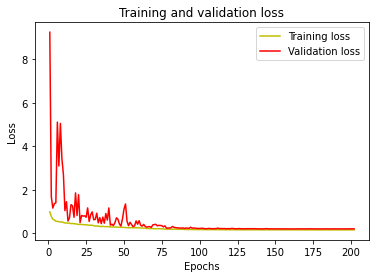

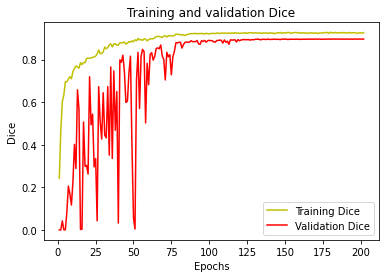

In [13]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']

plt.plot(epochs, acc, 'y', label='Training Dice')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()